# Kannusteet, työllistymis- ja efektiivinen veroaste
Antti Tanskanen,
19.9.2019

Efektiivinen veroaste kertoo, paljonko ansaituista lisäansioista menee verojen kasvamiseen ja etuuksien pienenemisen. Työllistymisveroaste taas kertoo, mikä osuus siirtyminen työttömyydestä työhön tuomista palkkatuloista menee veroihin ja etuuksien pienenemiseen. Tulokset ovat erilaisille perheille erilaisia, erityisesti johtuen erilaisista etuuksista. Työllistymisveroaste määritellään

$$
V=1-\frac{T_2-T_1}{\Delta t},
$$

missä $T_1$ on nettotulot työttömänä sisältäen etuudet, $T_2$ on nettotulot työllistyneenä, $\Delta t$ on työstä saatava palkka. Efektiivinen marginaalivero lasketaan samalla kaavalla.

Jos esimerkiksi työttömänä käteen jää 100 e/kk, ja työllistyneenä 500 euron kuukausipalkasta jää 300 e/kk käteen verojen ja etuuksien pienentymisen jälkeen, on työllistymisveroaste 60 prosentti.

Efektiivinen marginaalivero kertoo, paljonko lisätulosta menee veroihin yms. Jos tulotaso nyt on 1500 e/kk ja siitä jää käteen etuudet mukaanlukien 1400 e/kk. Jos lisätyöllä bruttotulon saa nostettua 2000 euroon kuukaudessa, josta jää 1600 e/kk käteen (etuudet mukana), on efektiivinen veroaste 60 prosenttia.

Tarkempaa tietoa veroasteiden laskennasta löytyy esimerkiksi julkaisuista Kärkkäinen ja Tervola [2018] ja Viitamäki [2015].

## Python-kirjasto

Tässä työkirjassa esitellään Python-kirjasto fin_benefit, jonka avulla on helppo tarkastella käteen jäävien tulojen osuutta, efektiivistä marginaaliveroa ja työllistymisveroastetta. Kirjasto on melko suppea, noin 2 000 riviä koodia yhteensä.

In [1]:
# for Colab, install fin_benefits from Github
#!pip install git+https://github.com/ajtanskanen/benefits.git

In [2]:
# haetaan tarpeelliset kirjastot
import fin_benefits # määrittelee luokan, jossa on sosiaaliturvafunktiot yms
import numpy as np 

# kuvat suuremmiksi
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

## Tyyppitapauksia ja niiden korvausasteita

Laskee työllisyysveroaste, työnteon efektiivisen marginaalivero ja käteen jäävä ansio kirjaston avulla. Valitaan ensin tyyppitapaus. Muuttuja p kertoo tarkat tiedot laskennankohteesta, selite sisältää kuvauksen siitä ja parametri tulosta kehottaa printtaamaan selite:en.

In [3]:
p,selite=fin_benefits.perheparametrit(perhetyyppi=12,tulosta=True)

Perhe, jossa 2 aikuista ja 2 lasta. Lapsista 2 on päivähoidossa. Työtön (työmarkkinatuki), puoliso töissä (palkka 1250 e/kk). Asumismenot asumistuessa 980 e/kk


Tarkastetaan vielä, millaisia parametrejä p:hen on syötetty

Itse laskenta koostuu kahdesta rivistä koodia. Alustetaan objektia ben kirjastosta fin_benefits. Tämän jälkeen sitä voi kutsua laskemaan marginaalit ja plottamaan ne.

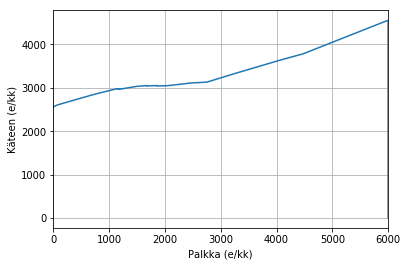

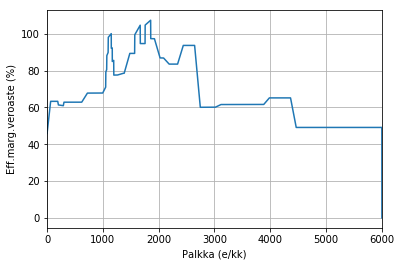

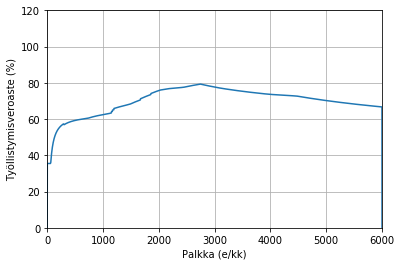

In [4]:
# Luokka Benefits() sisältää koodin
ben=fin_benefits.Benefits()

# ja lasketaan & plotataan tulokset
basenetto,baseeff,basetva=ben.laske_ja_plottaa(p)

Jaotellaan vielä marginaalit niiden lähteiden mukaan

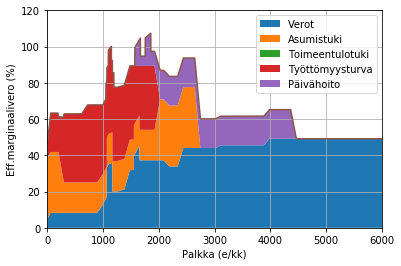

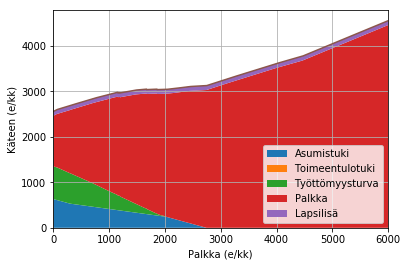

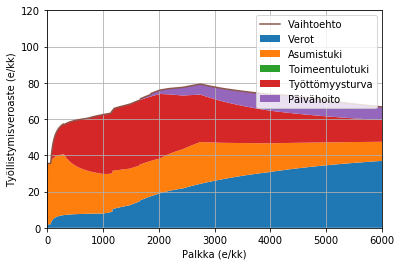

In [5]:
# ja lasketaan & plotataan tulokset
ben.laske_ja_plottaa_marginaalit(p)

# Etuuslajien muokkaus
Etuuslajien muokkaaminen on helppoa: kopioidaan luokka Benefits ja korvataan haluttu etuusmuoto uudella.

Esimerkin vuoksi korvataan toimeentulotuki yhteensovittamattomalla 750 e/kk tuella. Tämä on eräänlainen perustulo, mutta se ei ole kustannusneutraali ilman muutoksia verotukseen

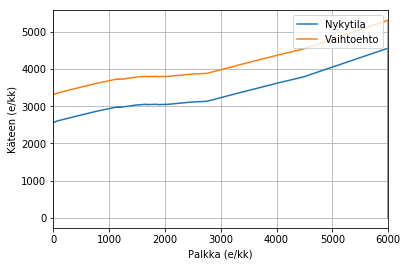

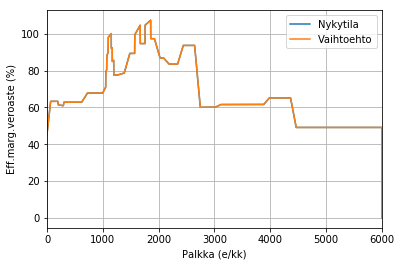

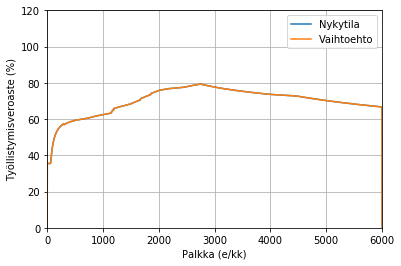

In [6]:
## uusi toimeentulotuki

# Ensin kloonataan Luokka Benefits() sisältää koodin
class Suurempituki(fin_benefits.Benefits):
    def toimeentulotuki(self,omabruttopalkka,omapalkkavero,puolison_bruttopalkka,puolison_palkkavero,muuttulot,verot,asumismenot,muutmenot,p):
        return 750

# Luokka Suurempituki() sisältää koodin
perustulo=Suurempituki()

# ja lasketaan & plotataan tulokset
_,_,_=perustulo.laske_ja_plottaa(p,basenetto=basenetto,baseeff=baseeff,basetva=basetva)

# EK:n malli


## Muokataan asumistukea
Entä jos asumistuessa suojaosa olisi perhekohtainen ja palkkatuloa kohdeltaisiin lievemmin kuin muuta tuloa?

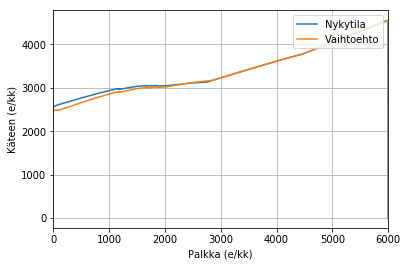

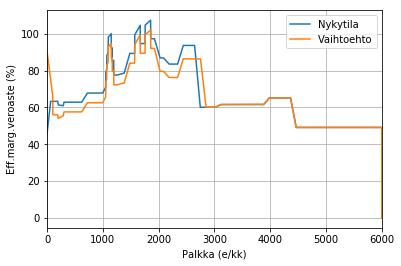

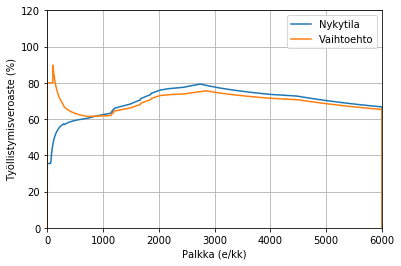

In [7]:
## uusi asumistuki

# Ensin kloonataan luokka Benefits(), joka sisältää koodin
class Parempituki(fin_benefits.Benefits):
    def asumistuki(self,palkkatulot,muuttulot,vuokra,p):
        max_menot=np.array([[508,492,411,362],[735,706,600,527],[937,890,761,675],[1095,1038,901,804]])
        max_lisa=np.array([137,130,123,118])
        max_meno=max_menot[min(3,p['aikuisia']+p['lapsia']-1),p['kuntaryhma']]+max(0,p['aikuisia']+p['lapsia']-4)*max_lisa[p['kuntaryhma']]

        prosentti=0.70
        suojaosa=300 # per talous, ei per aikuiset
        perusomavastuu=max(0,0.47*(0.8*max(0,palkkatulot-suojaosa)+0.9*muuttulot-(542+90*p['aikuisia']+200*p['lapsia'])))
        tuki=max(0,(min(max_meno,vuokra)-perusomavastuu)*prosentti);

        return tuki
    
    def toimeentulotuki(self,omabruttopalkka,omapalkkavero,puolison_bruttopalkka,puolison_palkkavero,muuttulot,verot,asumismenot,muutmenot,p,omavastuuprosentti=0.0):
    
        # kutsutaan alkuperäistä 7%:n omavastuuprosenttikertoimella
        return super().toimeentulotuki(omabruttopalkka,omapalkkavero,puolison_bruttopalkka,puolison_palkkavero,muuttulot,verot,asumismenot,muutmenot,p,omavastuuprosentti=0.07)

# Luokka Parempituki() sisältää koodin
tuki=Parempituki()

# ja lasketaan & plotataan tulokset
_,_,_=tuki.laske_ja_plottaa(p,basenetto=basenetto,baseeff=baseeff,basetva=basetva)

# Päivähoitomaksut alemmas ja porrastetaan työttömyysturvaa

Tehdään muutoksia asumistukeen (kuten yllä), toimeentulotukeen (7% asumiskulujen omavastuu), porrastetaan työttömyysturva (+5% 3kk, -5% 6kk, -15% siitä eteenpäin)


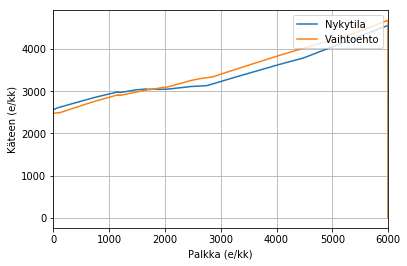

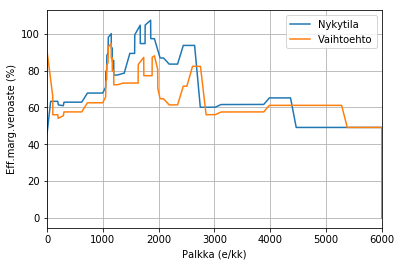

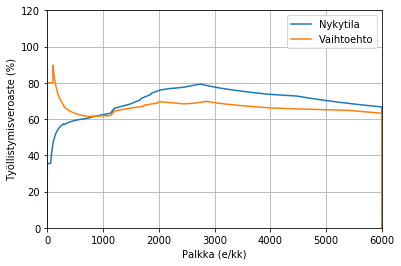

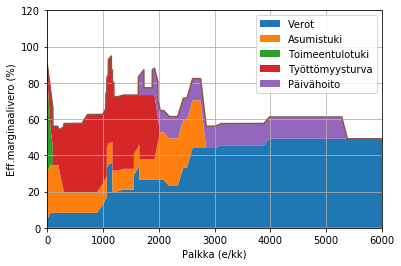

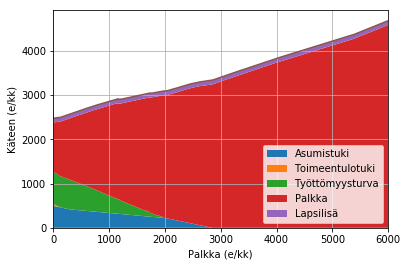

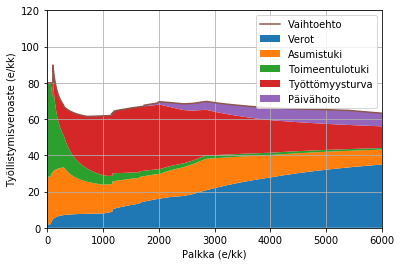

In [8]:
# Ensin kloonataan luokka Benefits(), joka sisältää koodin
class EKmalli(Parempituki):
    def paivahoitomenot(self,hoidossa,tulot,p):
        # kutsutaan alkuperäistä funktiota eri maksuprosentilla
        return super().paivahoitomenot(hoidossa,tulot,p,prosentti1=0.08)
    
    def ansiopaivaraha(self,tyoton,vakiintunutpalkka,lapsia,tyotaikaisettulot,saa_ansiopaivarahaa,kesto,p,ansiokerroin=1.0):
        if tyoton>0:
            # porrastetaan ansio-osa keston mukaan
            if kesto>6*25:
                kerroin=0.85
            elif kesto>3*25:
                kerroin=0.95
            else:
                kerroin=1.05
        else:
            kerroin=0.0

        # kutsutaan alkuperäistä ansiopäivärahaa kertoimella
        return super().ansiopaivaraha(tyoton,vakiintunutpalkka,lapsia,tyotaikaisettulot,saa_ansiopaivarahaa,kesto,p,ansiokerroin=kerroin)

    # yläraja 80% ansionalenemasta
    def ansiopaivaraha_ylaraja(self,ansiopaivarahamaara,tyotaikaisettulot,vakpalkka,vakiintunutpalkka):
        return min(ansiopaivarahamaara,0.8*max(0,vakiintunutpalkka-tyotaikaisettulot))   
     
    def tyotulovahennys(self):
        max_tyotulovahennys=3000/self.kk_jakaja
        ttulorajat=np.array([2500,33000,127000])/self.kk_jakaja
        ttulopros=np.array([0.120,0.0165,0])
        return max_tyotulovahennys,ttulorajat,ttulopros


# Luokka EKmalli() sisältää koodin
ek=EKmalli()

# ja lasketaan & plotataan tulokset
_,_,_=ek.laske_ja_plottaa(p,basenetto=basenetto,baseeff=baseeff,basetva=basetva)
ek.laske_ja_plottaa_marginaalit(p,basenetto=basenetto,baseeff=baseeff,basetva=basetva)

# Määritellään uusi esimerkkitapaus

Ennaltamääriteltyjen tyyppitapausten lisäksi on helppo määritellä uusia. 

In [9]:
p={'tyoton': 1, 'ika': 30, 'saa_ansiopaivarahaa': 1, 'piikit_pois': 0, 't': 0, 'vakiintunutpalkka': 1500, 'elakkeella': 0, 'asumismenot_toimeentulo': 1150, 'asumismenot_asumistuki': 1024, 'lapsia': 2, 'paivahoidossa': 2, 'aikuisia': 2, 'veromalli': 0, 'kuntaryhma': 2, 'lapsia_kotihoidontuella': 0, 'alle3v': 0, 'ansiopvrahan_suojaosa': 1, 'ansiopvraha_lapsikorotus': 1, 'puolison_tulot': 2500, 'puoliso_tyoton': 0, 'puoliso_vakiintunutpalkka': 0, 'puoliso_saa_ansiopaivarahaa': 0, 'puolison_vakiintunutpalkka': 2500, 'asumismenot_yhdistetty': 1150, 'puolison_tyottomyyden_kesto':10, 'tyottomyyden_kesto': 10}
print(fin_benefits.tee_selite(p))

Perhe, jossa 2 aikuista ja 2 lasta. Lapsista 2 on päivähoidossa. Työtön (ansiopaivaraha, vakiintunut ansio 1500 e/kk), puoliso töissä (palkka 2500 e/kk). Asumismenot asumistuessa 1150 e/kk


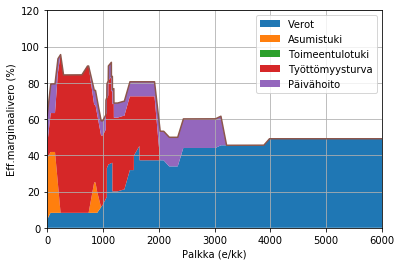

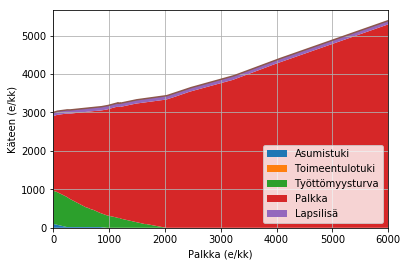

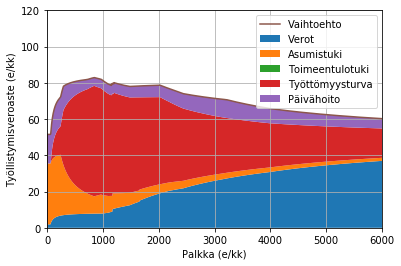

In [10]:
# ja lasketaan & plotataan tulokset
ben.laske_ja_plottaa_marginaalit(p)

# Piikit efektiivisessä marginaaliverossa

Riippuen siitä, millaisia lisätuloja oletetaan, muuttuvat tulokset. Peruslaskelmassa dt=100 e/kk, joten vrrataan sitä dt=1 e/kk:hon.

Perhe, jossa 2 aikuista ja 2 lasta. Lapsista 2 on päivähoidossa. Työtön (ansiopaivaraha, vakiintunut ansio 1500 e/kk), puoliso töissä (palkka 2500 e/kk). Asumismenot asumistuessa 980 e/kk


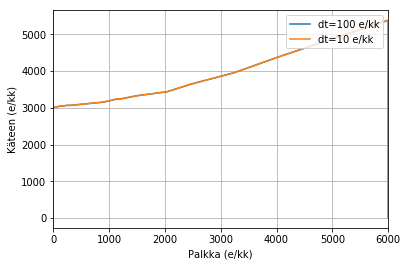

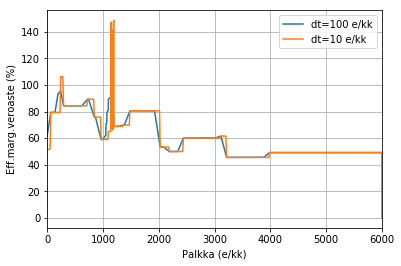

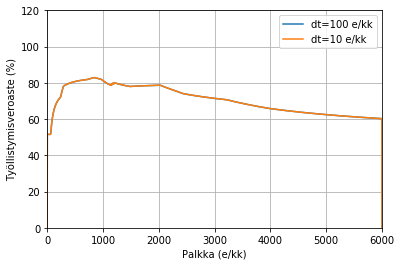

In [11]:
p3,selite=fin_benefits.perheparametrit(perhetyyppi=13,tulosta=True)
base2netto,base2eff,base2tva=ben.laske_ja_plottaa(p3,plottaa=False)

# ja lasketaan & plotataan tulokset
dt=10
_,_,_=ben.laske_ja_plottaa(p3,basenetto=base2netto,baseeff=base2eff,basetva=base2tva,\
                           dt=dt,otsikko='dt=10 e/kk',otsikkobase='dt=100 e/kk')

Kuten yllä olevat kuvat näyttävät, on valitulla lisäansioiden määrällä vaikutusta tuloksiin efektiivisessä marginaaliverossa, mutta ei työllistymisveroasteessa tai käteen jäävässä tulonmäärässä. Työllistymisveroaste ei riipu lisäansioiden määrästä, joten siinä ei pidäkään olla piikkejä. Jos lisäansio on pieni, ovat piikit efektiivisessä marginaaliverossa suuria johtuen kynnyksistä erilaisissa maksuissa, koska tällöin ansionlisäys voi viedä tulot yli kynnyksen.

# Kokoelma esimerkkitapauksia

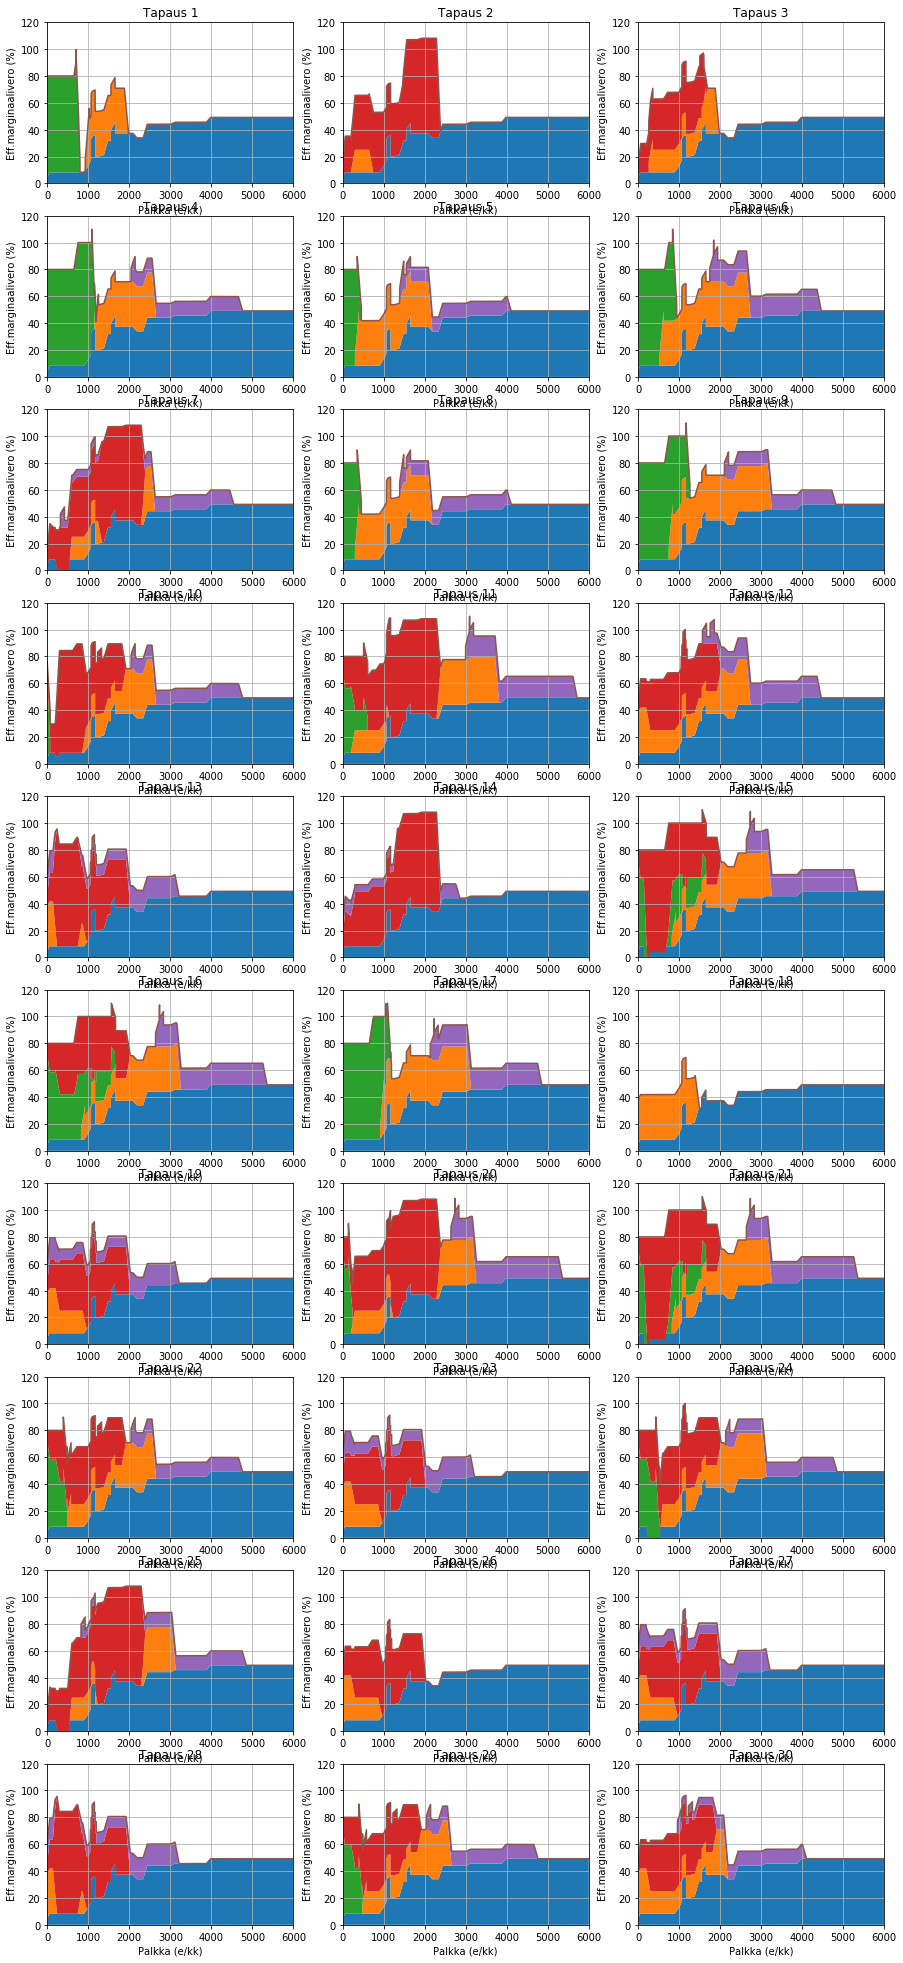

In [12]:
# tämän laskenta on aika hidasta
#plt.rcParams['figure.figsize'] = [15, 35]
#ben.laske_ja_plottaa_hila()
#plt.rcParams['figure.figsize'] = [10, 5]

# Kirjallisuus

[1] Viitamäki, H. Työnteon kannustimet - mitä jää käteen? VATT muistiot 50, https://vatt.fi/documents/2956369/3012213/muistio_50.pdf, 2015

[2] Kärkkäinen, O., Tervola, J. Talouspolitiikan vaikutukset tuloeroihin ja työllisyyteen 2015–2018, Valtioneuvoston selvitys- ja tutkimustoiminnan julkaisusarja 59/2018, http://julkaisut.valtioneuvosto.fi/handle/10024/161061, 2018